# NYC Metro Challenge

## Field Description

- C/A = Control Area (A002)
- UNIT = Remote Unit for a station (R051)
- SCP = Subunit Channel Position represents an specific address for a device (02-00-00)
- DATEn = Represents the date (MM-DD-YY)
- TIMEn = Represents the time (hh:mm:ss) for a scheduled audit event
- DEScn = Represent the "REGULAR" scheduled audit event (occurs every 4 hours)
- ENTRIESn = The cumulative entry register value for a device
- EXISTn = The cumulative exit register value for a device

In [68]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style='darkgrid')

import glob
import shutil
import py7zr

## Importing datasets

### Data processing methods

In [69]:
def time_covariates(df, time_column):
      
    df[time_column] = pd.to_datetime(df[time_column])
    
    df['year'] = df[time_column].dt.year.astype('int16')
    df['month'] = df[time_column].dt.month.astype('int8')
    df['weekday'] = df[time_column].dt.weekday.astype('int8')
    df['day'] = df[time_column].dt.day.astype('int8')
    
    df.drop(time_column, axis=1, inplace=True)
    
    return df

In [82]:
def object_to_cat(df):
    
    object_columns = [_ for _ in df.columns if df[_].dtype == np.object0]
    
    for column in object_columns:
        df[column] = pd.Categorical(df[column])
    
    return df

In [86]:
def counts_to_int(df):
    
    df.dropna(inplace=True)
    df['entries'] = df['entries'].astype('int64')
    df['exits'] = df['exits'].astype('int64')
    
    return df

In [84]:
def data_grouping(df, target_columns):
    
    object_columns = [_ for _ in df.columns if df[_].dtype == np.object0]
    time_columns = ['year', 'month']
    
    df_grouped = df.groupby(time_columns + object_columns)[target_columns].sum().reset_index()
    
    for column in object_columns:
        df_grouped[column] = pd.Categorical(df_grouped[column])
    
    return df_grouped

## Importing datasets

Declaring the folders.

In [72]:
file_name = glob.glob('data/*')
temp_folder = 'data/temp'

Unpacking the 7zip file.

In [74]:
with py7zr.SevenZipFile(file_name[0], 'r') as archive:
    archive.extractall(path=temp_folder)

path_data_sets = glob.glob(temp_folder + '/*/*')

Datasets are read from the file, pre-processed using data processing methods, and concatenated into a single data frame.

In [87]:
df = pd.concat([counts_to_int(object_to_cat(time_covariates(pd.read_csv(_), 'time'))) for _ in path_data_sets], ignore_index=True)
df.dropna(inplace=True)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79130015 entries, 0 to 79130014
Data columns (total 13 columns):
 #   Column    Dtype   
---  ------    -----   
 0   ca        object  
 1   unit      object  
 2   scp       object  
 3   station   object  
 4   linename  object  
 5   division  category
 6   desc      object  
 7   entries   int64   
 8   exits     int64   
 9   year      int16   
 10  month     int8    
 11  weekday   int8    
 12  day       int8    
dtypes: category(1), int16(1), int64(2), int8(3), object(6)
memory usage: 5.2+ GB


Removing temporary folder with files.

In [89]:
try:
    shutil.rmtree(temp_folder)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

Exporting the pre-processed file to save time.

In [90]:
df.to_parquet('data/df_processed.gzip', compression='gzip')

## Exploratory data analysis

In [ ]:
df = pd.read_parquet('data/df_processed.gzip')
df.info()

Filtering only the auditions events with `desc='REGULAR'`

In [92]:
df = df[df['desc'] == 'REGULAR']

Since the input and output data are a cumulative count, we calculate the difference between each audition.

In [58]:
df = df.sort_values(by=['station', 'scp', 'year', 'month', 'day'])
df['entries_diff'] = df.groupby(['station', 'scp', 'year', 'month', 'day'])['entries'].diff().fillna(0)
df['exits_diff'] = df.groupby(['station', 'scp', 'year', 'month', 'day'])['exits'].diff().fillna(0)

In [59]:
df.head()

,ca,unit,scp,station,linename,division,desc,entries,exits,year,month,weekday,day,entries_diff,exits_diff
62012788,H007,R248,00-00-00,1 AV,L,BMT,REGULAR,10553130.0,11502084.0,2016,1,4,1,0.0,0.0
62017334,H007,R248,00-00-00,1 AV,L,BMT,REGULAR,10553984.0,11503179.0,2016,1,4,1,854.0,1095.0
62021884,H007,R248,00-00-00,1 AV,L,BMT,REGULAR,10554367.0,11503841.0,2016,1,4,1,383.0,662.0
62026428,H007,R248,00-00-00,1 AV,L,BMT,REGULAR,10554479.0,11504183.0,2016,1,4,1,112.0,342.0
62030974,H007,R248,00-00-00,1 AV,L,BMT,REGULAR,10554673.0,11504515.0,2016,1,4,1,194.0,332.0


In [60]:
df.describe()

,entries,exits,year,month,weekday,day,entries_diff,exits_diff
count,7.168958e+07,7.168958e+07,7.168958e+07,7.168958e+07,7.168958e+07,7.168958e+07,7.168958e+07,7.168958e+07
mean,1.607794e+07,1.264155e+07,2.013607e+03,6.510888e+00,2.984497e+00,1.570297e+01,5.768781e+05,4.159224e+05
std,1.237187e+08,1.110802e+08,2.158210e+00,3.365155e+00,2.000400e+00,8.782082e+00,1.095543e+08,9.397366e+07
min,-9.811392e+08,-9.961133e+08,2.010000e+03,1.000000e+00,0.000000e+00,1.000000e+00,-2.147369e+09,-2.097170e+09
25%,4.435080e+05,2.472760e+05,2.012000e+03,4.000000e+00,1.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00
50%,2.158648e+06,1.330433e+06,2.014000e+03,7.000000e+00,3.000000e+00,1.600000e+01,6.400000e+01,4.500000e+01
75%,5.335336e+06,3.931534e+06,2.015000e+03,9.000000e+00,5.000000e+00,2.300000e+01,4.070000e+02,2.980000e+02
max,2.147484e+09,2.097170e+09,2.017000e+03,1.200000e+01,6.000000e+00,3.100000e+01,2.862954e+09,2.858371e+09


In [61]:
df.isna().sum()

ca              0
unit            0
scp             0
station         0
linename        0
division        0
desc            0
entries         0
exits           0
year            0
month           0
weekday         0
day             0
entries_diff    0
exits_diff      0
dtype: int64

In [62]:
group_1 = df.groupby(['year', 'month'])['entries_diff'].sum().reset_index()

<AxesSubplot:xlabel='month', ylabel='entries_diff'>

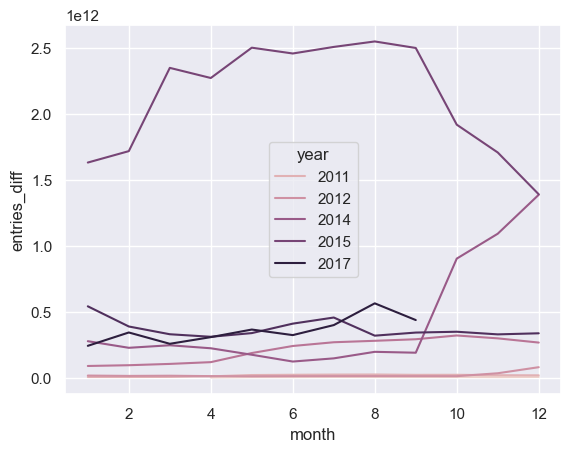

In [63]:
sns.lineplot(data=group_1, x='month', y='entries_diff', hue='year')

In [64]:
df.sort_values(by='unit')

,ca,unit,scp,station,linename,division,desc,entries,exits,year,month,weekday,day,entries_diff,exits_diff
33880049,A060,R001,00-00-03,WHITEHALL ST,R1,BMT,REGULAR,162577.0,80638.0,2013,5,0,13,263.0,280.0
20289838,A060,R001,00-00-07,WHITEHALL ST,R1,BMT,REGULAR,4734061.0,727989.0,2012,2,1,28,117.0,2.0
20294366,A060,R001,00-00-07,WHITEHALL ST,R1,BMT,REGULAR,4734089.0,727989.0,2012,2,1,28,28.0,0.0
20305527,A060,R001,00-00-07,WHITEHALL ST,R1,BMT,REGULAR,4734426.0,728474.0,2012,2,1,28,337.0,485.0
20310867,A060,R001,00-00-07,WHITEHALL ST,R1,BMT,REGULAR,4734814.0,728486.0,2012,2,1,28,388.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78202397,N702,R572,00-05-01,96 ST-2 AVE,Q,IND,REGULAR,1.0,196.0,2017,8,4,4,0.0,0.0
78197744,N702,R572,00-05-01,96 ST-2 AVE,Q,IND,REGULAR,1.0,196.0,2017,8,4,4,0.0,0.0
78193025,N702,R572,00-05-01,96 ST-2 AVE,Q,IND,REGULAR,1.0,196.0,2017,8,4,4,0.0,0.0
78296419,N702,R572,00-05-01,96 ST-2 AVE,Q,IND,REGULAR,1.0,197.0,2017,8,0,7,0.0,0.0


In [65]:
group_2 = df.groupby(['station', 'scp','weekday'])['entries_diff'].mean().reset_index()

<AxesSubplot:xlabel='weekday', ylabel='entries_diff'>

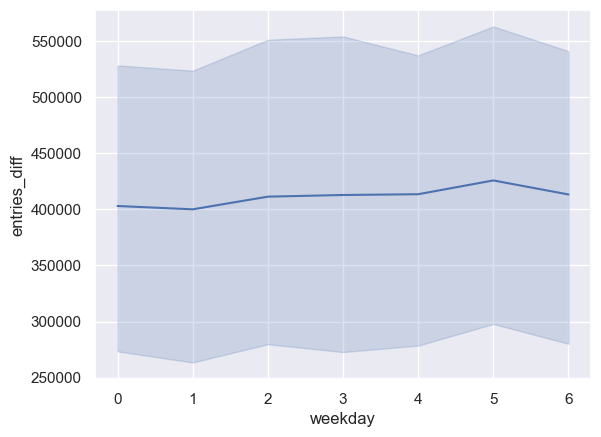

In [66]:
sns.lineplot(data=group_2, x='weekday', y='entries_diff')